Adapted code from http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html

In [2]:
from __future__ import print_function 
from __future__ import division
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy
import skimage.transform
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


loading back in model:

In [3]:
model = torch.load('full_group_resnet.pt')
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# Class Activation Mapping

In [4]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()
        
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

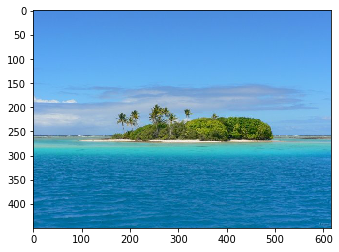

In [46]:
climates = ['Arctic', 'Cold_Arid', 'Hot_Arid', 'Hot_Continental', 'Humid_Subtropical', 'Mediterranean', 'Ocean', 'Oceanic', 'Subarctic', 'Tropical_Monsoon', 'Tropical_Rainforest', 'Tropical_Savanna', 'Warm_Continental']

filenames = ["00_Af_australia_daintree1.jpg", 
             "00_Af_drc_ituri.jpg",
             "00_Af_malaysia_canopy.jpg", 
             "01_Am_australia_cairns1.jpg", 
             "01_Am_bangladesh_foyslake3.jpg",
             "01_Am_bangladesh_foyslake3.jpg", 
             "02_Aw_guinea_fouta.jpg", 
             "02_Aw_venezuela_caracas.jpg", 
             "02_Aw_venezuela_gransabana.jpg", 
             "02_Aw_venezuela_losllanos.JPG", 
             "03_BSh_mali_sahel.jpg", 
             "03_BSh_niger_niamey.jpg", 
             "03_BWh_algeria_sahara.jpg",
             "03_BWh_libya_sahara.jpg",
             "04_BWk_china_taklamakan.jpg", 
             "04_BWk_india_leh.jpg", 
             "04_BWk_mongolia_gobi.jpg", 
             "05_CSa_ca_losangeles.jpg", 
             "05_CSa_france_languedoc.jpg", 
             "05_CSa_greece_lefkada.JPG", 
             "08_Dfa_japan_hokkaidouni.jpg", 
             "10_Dfc_canada_lakelouise.jpg",
             "11_EF_antarctica_vostok.jpg",
             "11_ET_greenland.jpg", 
             "12_Ocean_atlantic.jpg", 
             "12_Ocean_ca_sunset.JPG", 
             "12_Ocean_greece_lefkada.jpg", 
             "12_Ocean_frenchpolynesia_tahuna.jpg", ]

image = Image.open("12_Ocean_frenchpolynesia_tahuna.jpg")
plt.imshow(image)

In [47]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   #transforms.RandomResizedCrop((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

tensor = preprocess(image)
#plt.imshow(tensor.permute(1,2,0))

In [48]:
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)
prediction = model(prediction_var)
pred_probabilities = nn.functional.softmax(prediction, dim=1).data.squeeze()
activated_features.remove()
top = torch.topk(pred_probabilities,3)[1].cpu().numpy()
torch.topk(pred_probabilities,3)

torch.return_types.topk(
values=tensor([0.5629, 0.3636, 0.0217], device='cuda:0'),
indices=tensor([10,  9,  8], device='cuda:0'))

In [62]:
k = 2
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
weight_softmax_params
class_idx = torch.topk(pred_probabilities,3)[1][k].int()
print(class_idx)
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

tensor(8, device='cuda:0', dtype=torch.int32)


In [50]:
#plt.imshow(overlay[0], alpha=0.5, cmap='jet')

tensor([0.5629, 0.3636, 0.0217], device='cuda:0')
tensor([10,  9,  8], device='cuda:0')
Tropical_Rainforest Tropical_Monsoon Subarctic


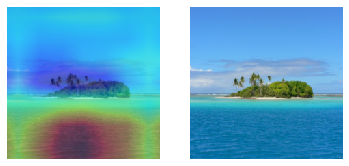

In [63]:
print(torch.topk(pred_probabilities,3)[0])
print(torch.topk(pred_probabilities,3)[1])
print(climates[top[0]],climates[top[1]],climates[top[2]]);

ax = plt.subplot(1, 2, 1)
plt.imshow(display_transform(image))
plt.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')
ax.axis('off');
ax = plt.subplot(1, 2, 2)
plt.imshow(display_transform(image))
ax.axis('off');